The output in looker studio:
[LINK](https://lookerstudio.google.com/embed/reporting/2d94a92e-7881-4adf-bfd7-c32a2c5b77fb/page/axcID)

Clustering with KMeans

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [5]:
# standardize the scores based on lights

# Load the CSV data
df = pd.read_csv('datasets/latest_scores.csv')

# Create a dictionary to map categories to their score ranges
score_ranges = {
    "RSDQE": [(0, 3), (4, 4), (5, 10)],
    "RSDQB": [(0, 2), (3, 3), (4, 10)],
    "RSDQH": [(0, 5), (6, 6), (7, 10)],
    "RSDQP": [(0, 2), (3, 3), (4, 10)],
    "RIDELA": [(6, 10), (5, 5), (0, 4)],
}

def standardize_score(row):
    name = row["name"]
    score = row["score"]
    ranges = score_ranges[name]

    # Find the corresponding range for the score
    for i, r in enumerate(ranges):
        if r[0] <= score <= r[1]:
            if i == 0:  # Green
                if name == "RIDELA":
                    return (r[1] - score)/(r[1] - r[0]) * 0.5
                else:
                    return (score - r[0])/(r[1] - r[0]) * 0.5
            elif i == 1:  # Orange
                return 0.5
            elif i == 2:  # Red
                if name == "RIDELA":
                    return 0.5 + (r[1] - score) / (r[1] - r[0]) * 0.5
                else:
                    return 0.5 + (score - r[0]) / (r[1] - r[0]) * 0.5

# Apply the standardize_score function to each row and create a new column with standardized scores
df["standardized"] = df.apply(standardize_score, axis=1)

# Save the new DataFrame to a CSV file
df.to_csv("datasets/standardized_scores.csv", index=False)


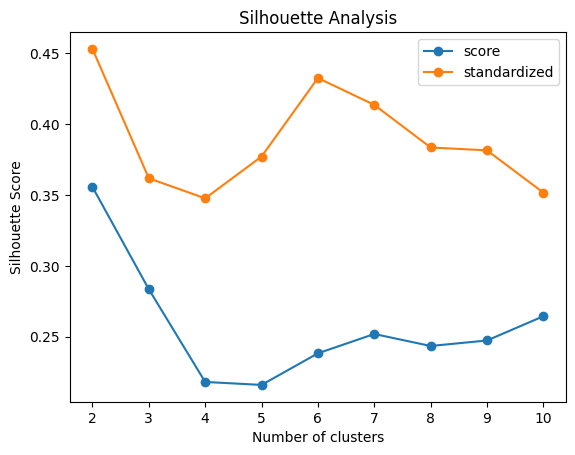

Best number of clusters for score column: 2
Best number of clusters for standardized column: 2


In [14]:
# Load the CSV file
csv_file = "datasets/standardized_scores.csv"
df = pd.read_csv(csv_file)

# Pivot the data to have each 'name' as a separate feature
pivot_df = df.pivot_table(index="child_id", columns="name", values="score").fillna(0).reset_index()

# Train KMeans with different values of k and store the silhouette scores
sil_scores = []
best_sil_scores = 0
best_scores_cluster = 0
k_values = list(range(2, 11))


# Pivot the data to have each 'name' as a separate feature (using standardized column)
pivot_df_standardized = df.pivot_table(index="child_id", columns="name", values="standardized").fillna(0).reset_index()

# Train KMeans with different values of k and store the silhouette scores for standardized values
sil_scores_standardized = []
best_sil_standardized = 0
best_standardized_cluster = 0

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=44)
    labels = kmeans.fit_predict(pivot_df.iloc[:, 1:])
    sil_score = silhouette_score(pivot_df.iloc[:, 1:], labels)
    if sil_score > best_sil_scores:
        best_sil_scores = sil_score
        best_scores_cluster = k
    sil_scores.append(sil_score)

for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=44)
    labels = kmeans.fit_predict(pivot_df_standardized.iloc[:, 1:])
    sil_score = silhouette_score(pivot_df_standardized.iloc[:, 1:], labels)
    if sil_score > best_sil_standardized:
        best_sil_standardized = sil_score
        best_standardized_cluster = k
    sil_scores_standardized.append(sil_score)

# Plot the silhouette scores against the number of clusters for both score and standardized values
plt.plot(k_values, sil_scores, marker='o', label="score")
plt.plot(k_values, sil_scores_standardized, marker='o', label="standardized")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.legend()
plt.show()

print("Best number of clusters for score column:", best_scores_cluster)
print("Best number of clusters for standardized column:", best_standardized_cluster)

In [17]:
# Train KMeans with the best number of clusters (k=2 in this case) for score values
kmeans_score = KMeans(n_clusters=best_scores_cluster, n_init='auto', random_state=44)
labels_score = kmeans_score.fit_predict(pivot_df.iloc[:, 1:])

# Train KMeans with the best number of clusters (k=2 in this case) for standardized values
kmeans_standardized = KMeans(n_clusters=best_standardized_cluster, n_init='auto', random_state=44)
labels_standardized = kmeans_standardized.fit_predict(pivot_df_standardized.iloc[:, 1:])

# Add cluster labels to the pivoted DataFrames
pivot_df['cluster_score'] = labels_score
pivot_df_standardized['cluster_standardized'] = labels_standardized

# Merge the original DataFrame with the pivoted DataFrames to add the 'cluster_score' and 'cluster_standardized' columns
df_with_clusters = pd.merge(df, pivot_df[['child_id', 'cluster_score']], on='child_id')
df_with_clusters = pd.merge(df_with_clusters, pivot_df_standardized[['child_id', 'cluster_standardized']], on='child_id')

# Save the updated DataFrame as a new CSV file
df_with_clusters.to_csv("datasets/data_with_clusters.csv", index=False)